# Model Implementation

## Initialize Packages

In [82]:
import sys
import pandas as pd
import numpy as np
import os
import rich
import xgboost as xgb
import json
import joblib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_tweedie_deviance
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

In [58]:
parent_dir = os.path.abspath("..")
sys.path.append(parent_dir)

from analysis_tool_chest.data_exploration import PredictivenessCheck
from analysis_tool_chest.model_selection import ModelEvaluation

## Load Data and Assign Predictors

In [73]:
model_data = pd.read_csv('../backend/model_data.csv')
final_model_data = pd.read_csv('../backend/train_df_final.csv')

In [74]:
final_model_data['claim_cst_per_exposure'] = final_model_data['claimcst0'] / final_model_data['exposure']
final_model_data.head(5)

,driving_history_score,credit_score,marital_status,time_driven,area,agecat_grouped,gender,veh_color,max_power,engine_type,veh_age,veh_body,veh_value,claimcst0,numclaims,clm,exposure,claim_cst_per_exposure
0,73.0,646.516469,0.0,1.0,1.0,2.0,0.0,0.0,161,2.0,1.0,0.0,5.80,2023.198184,1,1,0.362191,5585.998969
1,88.0,635.400369,1.0,2.0,0.0,1.0,0.0,4.0,100,0.0,3.0,0.0,5.67,3600.172234,1,1,0.632068,5695.859540
2,55.0,646.463131,0.0,2.0,2.0,1.0,0.0,3.0,74,3.0,1.0,0.0,5.90,2021.144067,1,1,0.367460,5500.307127
3,98.0,645.598794,0.0,3.0,1.0,1.0,1.0,0.0,121,0.0,2.0,0.0,4.79,4006.845492,1,1,0.802184,4994.920513
4,66.0,657.348612,1.0,2.0,2.0,2.0,1.0,1.0,75,3.0,2.0,0.0,6.68,2542.953931,1,1,0.485009,5243.106060


In [75]:
# Define the list of predictors
# Create predictor list
veh_pred_lst = ['veh_value', 'veh_body', 'veh_age', 'engine_type', 'max_power', 'veh_color']
policy_pred_lst = ['gender', 'agecat', 'e_bill' ]
driving_behavior_pred_lst = ['area', 'time_of_week_driven', 'time_driven']
demo_pred_lst = ['marital_status', 'low_education_ind', 'credit_score', 'driving_history_score']
pred_lst = veh_pred_lst + policy_pred_lst + driving_behavior_pred_lst + demo_pred_lst # Split the data into training and validation sets
# pred_lst = ['engine_type', 'gender', 'credit_score', 'veh_age', 'agecat', 'area']

train_data = model_data.loc[model_data['sample'] == '1|bld']
val_data = model_data.loc[model_data['sample'] == '2|val']
rich.print( train_data.shape, val_data.shape )
train_data.head(5)

(11204, 25)
(3796, 25)

,id,fold,sample,veh_value,exposure,veh_body,veh_age,gender,area,agecat,...,e_bill,time_of_week_driven,time_driven,trm_len,credit_score,low_education_ind,clm,numclaims,claimcst0,claim_cst_per_exposure
0,1,2,1|bld,5.80,0.362191,suv,2,f,b,1,...,0,weekday,12pm - 6pm,6,646.516469,0.0,1,1,2023.198184,5585.998969
1,2,3,1|bld,5.67,0.632068,stnwg,4,f,a,2,...,0,weekend,6am - 12pm,12,635.400369,0.0,1,1,3600.172234,5695.859540
2,3,1,1|bld,5.90,0.367460,sedan,2,f,c,2,...,0,weekday,6am - 12pm,12,646.463131,0.0,1,1,2021.144067,5500.307127
3,4,2,1|bld,4.79,0.802184,stnwg,3,m,b,4,...,1,weekday,6pm - 12am,12,645.598794,0.0,1,1,4006.845492,4994.920513
4,5,2,1|bld,6.68,0.485009,sedan,3,m,c,1,...,0,weekday,6am - 12pm,12,657.348612,0.0,1,1,2542.953931,5243.106060


In [70]:
target = 'claim_cst_per_exposure' 

# Use the full list of predictors you defined earlier for consistency
final_preds = [
    'driving_history_score', 'credit_score', 'marital_status',
    'time_driven', 'area', 'agecat_grouped', 'gender', 'veh_color',
    'max_power', 'engine_type', 'veh_age', 'veh_body', 'veh_value'
]

# Define X and y using the fully processed data file
X = final_model_data[final_preds].copy()
y = final_model_data[target]
exposure = final_model_data['exposure'].astype(float).clip(lower=1e-12)

print(f"Target variable set to: {target}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

KeyError: 'claim_cst_per_exposure'

# Random Forest

In [13]:
for col in X_train.select_dtypes("object"):
    X_train[col] = X_train[col].astype("category").cat.codes

In [ ]:
# Train Random Forest
rf = RandomForestRegressor(
    n_estimators=300,      # number of trees
    max_depth=None,        # no depth limit (fully grown trees)
    random_state=42,
    n_jobs=1
)

rf.fit(X_train, y_train)

# In-sample predictions
y_pred = rf.predict(X_train)

# Evaluate on training data
rmse = root_mean_squared_error(y_train, y_pred)
mae = mean_absolute_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print("Training Model Metrics")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")

Training Model Metrics
RMSE: 1479.17
MAE: 671.65
R²: 0.859


# XGBoost

In [15]:
model_data = pd.read_csv('../backend/model_data_cleaned.csv')
# 1. Re-encoding function for agecat
def group_age_category(cat):
    """Groups original agecat values into Young, Middle, or Elder."""
    if cat == 1:
        return 'Young'
    elif cat == 6:
        return 'Elder'
    else:
        return 'Middle'

# 2. Feature engineering: group 'veh_body'
def group_veh_body(body):
    """Groups vehicle body types, keeping common ones and setting the rest to 'OTHER'."""
    keep_bodies = ['SEDAN', 'STNWG', 'SUV', 'TRUCK', 'UTE', 'COUPE']
    if body in keep_bodies:
        return body
    else:
        return 'OTHER'
    
# --- Data Splitting and Feature Application ---
target = 'claimcst0'
train_data = model_data.loc[model_data['sample'] == '1|bld'].copy()
val_data = model_data.loc[model_data['sample'] == '2|val'].copy()

# APPLY FEATURE ENGINEERING TO BOTH TRAIN AND VAL DATA
# Apply agecat_grouped creation
train_data['agecat_grouped'] = train_data['agecat'].apply(group_age_category)
val_data['agecat_grouped'] = val_data['agecat'].apply(group_age_category)

# Apply veh_body grouping
train_data['veh_body'] = train_data['veh_body'].apply(group_veh_body)
val_data['veh_body'] = val_data['veh_body'].apply(group_veh_body)


# --- Define Final Predictor List ---
pred_lst = [
    'driving_history_score',
    'credit_score',
    'marital_status',
    'time_driven',
    'area',
    'agecat_grouped', # This will now exist!
    'gender',
    'veh_color',
    'max_power',
    'engine_type',
    'veh_age',
    'veh_body', # This will now be cleaned
    'veh_value'
]

# Define X and Y using the final list
X_train = train_data[pred_lst].copy()
X_val = val_data[pred_lst].copy()
y_train = train_data[target]
y_val = val_data[target]

# Redefine Num and Cat columns for the new list (needed for Target Encoding)
num_cols = ['driving_history_score', 'credit_score', 'time_driven', 'max_power', 'veh_age', 'veh_value']
cat_cols = [col for col in X_train.columns if col not in num_cols]

In [16]:
# --- 1. Fix the Column Type Lists (Crucial Step) ---
# Ensure 'time_driven' is treated as a CATEGORICAL column for encoding
num_cols = ['driving_history_score', 'credit_score', 'max_power', 'veh_age', 'veh_value']
cat_cols = [col for col in X_train.columns if col not in num_cols] # 'time_driven' is now correctly included here

# --- 2. Initialization ---
X_train_encoded = X_train.copy()
X_val_encoded = X_val.copy()

# --- 3. Apply Target Encoding (Now includes 'time_driven') ---
for col in cat_cols:
    # 1. Create a temporary DataFrame combining the feature (col) and the target
    temp_df = pd.DataFrame({'feature': X_train[col], 'target': y_train})
    
    # 2. Calculate the mean of the target for each category
    target_map = temp_df.groupby('feature')['target'].mean()

    # 3. Apply the calculated mean to both training and validation data
    X_train_encoded[col] = X_train_encoded[col].map(target_map)
    X_val_encoded[col] = X_val_encoded[col].map(target_map).fillna(y_train.mean())

    X_train_encoded[col] = X_train_encoded[col].astype(float)
    X_val_encoded[col] = X_val_encoded[col].astype(float)

# Finalize Processed DataFrames
X_train_processed = X_train_encoded
X_val_processed = X_val_encoded

# --- 4. Final Dtype Check (Should all be numeric now) ---
print("Final X_train_processed dtypes (looking for 'object'):")
print(X_train_processed.dtypes[X_train_processed.dtypes == 'object'])

Final X_train_processed dtypes (looking for 'object'):
Series([], dtype: object)


In [17]:
# 1. Create DMatrix (using the newly processed cleaned data)
dtrain = xgb.DMatrix(X_train_processed, label=y_train)

# 2. Define Parameters for XGBoost
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.05,
    'max_depth': 5,
    'seed': 42
}

# 3. Perform Cross-Validation to Find Optimal n_estimators
cv_results_cleaned = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=5000,           # Max number of boosting rounds to consider
    nfold=5,                        # 5-fold cross-validation
    metrics=('rmse', 'mae'),
    early_stopping_rounds=50,       # Stop if no improvement after 50 rounds
    seed=42,
)

# Extract the best number of rounds and performance
best_n_estimators_cleaned = cv_results_cleaned.shape[0]
best_rmse_cleaned = cv_results_cleaned['test-rmse-mean'].min()

print(f"Optimal n_estimators: {best_n_estimators_cleaned}")
print(f"CV Test RMSE: {best_rmse_cleaned:.4f}")

# 4. Train the Final Model on the entire training set
xgb_model_final_cleaned = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=best_n_estimators_cleaned
)
print("Final model training with cleaned data complete.")

Optimal n_estimators: 68
CV Test RMSE: 1842.2816
Final model training with cleaned data complete.


In [18]:
#Define objects (assuming X_train_processed and y_train are available)
xgb_model_rs = xgb.XGBRegressor(
    objective='reg:squarederror', random_state=42, n_jobs=-1, eval_metric='rmse' 
)
param_dist = {
    'n_estimators': randint(100, 1000), 'max_depth': randint(3, 10),                    
    'learning_rate': uniform(0.01, 0.2), 'subsample': uniform(0.6, 0.4),                 
    'colsample_bytree': uniform(0.6, 0.4), 'gamma': uniform(0, 0.5),                       
    'reg_alpha': uniform(0, 0.5),                   
}
random_search = RandomizedSearchCV(
    estimator=xgb_model_rs, param_distributions=param_dist, n_iter=50,
    scoring='neg_root_mean_squared_error', cv=5, random_state=42, verbose=1, n_jobs=-1
)

print("\nStarting NEW Randomized Hyperparameter Search for 'claimscst0'...")
random_search.fit(X_train_processed, y_train)

#Extract results
best_params = random_search.best_params_
best_rmse_tuned_claimcost = -random_search.best_score_ 
best_n_estimators = best_params.pop('n_estimators') # Extract n_estimators separately

print("\n--- Hyperparameter Tuning Results for claimscst0 ---")
print(f"Tuned CV RMSE (claimscst0): {best_rmse_tuned_claimcost:.4f}")
print(f"Best n_estimators: {best_n_estimators}")
print("\nBest Other Parameters Found:")
for k, v in best_params.items():
    print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")


Starting NEW Randomized Hyperparameter Search for 'claimscst0'...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

--- Hyperparameter Tuning Results for claimscst0 ---
Tuned CV RMSE (claimscst0): 1408.4056
Best n_estimators: 114

Best Other Parameters Found:
  colsample_bytree: 0.6944
  gamma: 0.1280
  learning_rate: 0.0181
  max_depth: 9
  reg_alpha: 0.0554
  subsample: 0.7757


In [19]:
#Define final model parameters (using the best parameters found)
final_params = {
    'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'seed': 42,
    'eta': best_params['learning_rate'], 'max_depth': best_params['max_depth'],
    'subsample': best_params['subsample'], 'colsample_bytree': best_params['colsample_bytree'],
    'gamma': best_params['gamma'], 'reg_alpha': best_params['reg_alpha']
}

print(f"\nTraining FINAL model with {best_n_estimators} estimators...")
#Defining the model with the correct variable name
xgb_model_final_tuned = xgb.train(
    params=final_params,
    dtrain=dtrain,
    num_boost_round=best_n_estimators
)


Training FINAL model with 114 estimators...


<Figure size 1000x800 with 0 Axes>

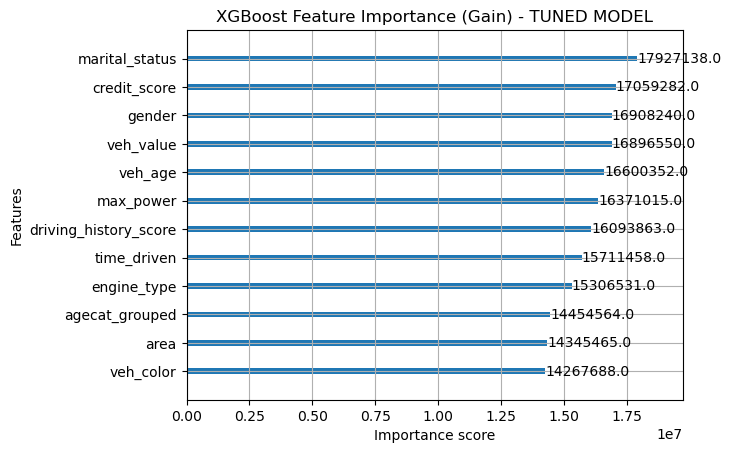


## Top 15 Features by Importance (Gain) - TUNED MODEL:
              Feature  Importance (Gain)
       marital_status         17927138.0
         credit_score         17059282.0
               gender         16908240.0
            veh_value         16896550.0
              veh_age         16600352.0
            max_power         16371015.0
driving_history_score         16093863.0
          time_driven         15711458.0
          engine_type         15306531.0
       agecat_grouped         14454564.0
                 area         14345465.0
            veh_color         14267688.0


In [20]:
# 1. Get feature importance scores using the FINAL TUNED MODEL
importance = xgb_model_final_tuned.get_score(importance_type='gain')

# 2. Convert to DataFrame and sort for plotting
importance_df = pd.DataFrame(
    list(importance.items()), 
    columns=['Feature', 'Importance (Gain)']
).sort_values(by='Importance (Gain)', ascending=False)

# 3. Plot the top 15 features
plt.figure(figsize=(10, 8))
try:
    xgb.plot_importance(
        xgb_model_final_tuned, 
        importance_type='gain', 
        max_num_features=15, 
        title='XGBoost Feature Importance (Gain) - TUNED MODEL'
    )
    plt.show()
except Exception:
    print("Could not plot feature importance directly. Displaying table instead.")
    
# Display the top 15 most important features
print("\n## Top 15 Features by Importance (Gain) - TUNED MODEL:")
print(importance_df.head(15).to_string(index=False))

In [21]:
#Generate predictions using the final tuned model on the training data
predictions_train = xgb_model_final_tuned.predict(dtrain)

#Calculate the R-squared score
r_squared_train = r2_score(y_train, predictions_train)

#Calculate the RMSE (Root Mean Square Error) for the training set
rmse_train = np.sqrt(np.mean((y_train - predictions_train)**2))

print(f"\n--- Final Model Evaluation on TRAINING Set ---")
print(f"Training R-squared (R^2): {r_squared_train:.4f}")
print(f"Training RMSE: {rmse_train:.4f}")


--- Final Model Evaluation on TRAINING Set ---
Training R-squared (R^2): 0.4216
Training RMSE: 1411.0192


## Frequency-Severity Modeling

In [76]:
# XGBoost Tweedie Regression with Cross-Validation Early Stopping and Native Categorical Support

final_preds = [
    'driving_history_score', # was supposed to drop, but this feels important for insurance
    'credit_score',
    # 'low_education_ind', # dropped based on results of varclushi
    'marital_status',
    'time_driven',
    'area',
    'agecat_grouped',
    'gender',
    'veh_color',
    'max_power',
    'engine_type',
    'veh_age',
    'veh_body',
    'veh_value' # were supposed to drop this but it doesn't make much sense to do
]

# Define features and target
y = final_model_data['claimcst0'].astype(float)
exposure = final_model_data['exposure'].astype(float).clip(lower=1e-12)
X = final_model_data[final_preds].copy()
# weights = train_data['exposure']  # Assuming exposure is in years, convert to months

In [77]:
# XGBoost DMatrix with offset
dtrain = xgb.DMatrix(
    X,
    label=y,
    base_margin=np.log(exposure)   # log exposure offset
)

# Define XGBoost parameters for Tweedie regression
params = {
    'objective': 'reg:tweedie',
    'eval_metric': 'tweedie-nloglik@1.5',
    'tweedie_variance_power': 1.5,
    'learning_rate': 0.01,
    'max_depth': 5,
    'min_child_weight': 100,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda': 1.0,
    'alpha': 0.0,
    'nthread': -1,
    'seed': 42,
    'tree_method': 'hist',
}

# Cross-validation with early stopping
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=5000,
    nfold=5,  # 5-fold cross-validation
    early_stopping_rounds=50,
    seed=42,
    verbose_eval=50
 )

# The best number of boosting rounds is:
best_num_boost_round = len(cv_results)
print(f"Best num_boost_round from CV: {best_num_boost_round}")

[0]	train-tweedie-nloglik@1.5:1121.95791+28.99751	test-tweedie-nloglik@1.5:1121.95260+115.99175
[50]	train-tweedie-nloglik@1.5:683.20436+17.56249	test-tweedie-nloglik@1.5:683.64458+70.71372
[100]	train-tweedie-nloglik@1.5:419.00838+10.66090	test-tweedie-nloglik@1.5:421.27272+42.92993
[150]	train-tweedie-nloglik@1.5:261.81308+6.47337	test-tweedie-nloglik@1.5:267.68766+27.41073
[200]	train-tweedie-nloglik@1.5:169.99478+3.91948	test-tweedie-nloglik@1.5:178.80651+18.08794
[250]	train-tweedie-nloglik@1.5:118.17256+2.51197	test-tweedie-nloglik@1.5:129.30706+12.71644
[300]	train-tweedie-nloglik@1.5:90.61002+1.67951	test-tweedie-nloglik@1.5:103.28925+9.63666
[350]	train-tweedie-nloglik@1.5:76.75980+1.26534	test-tweedie-nloglik@1.5:90.15112+7.94414
[400]	train-tweedie-nloglik@1.5:69.89636+1.06091	test-tweedie-nloglik@1.5:84.18511+7.03315
[450]	train-tweedie-nloglik@1.5:66.20871+1.01803	test-tweedie-nloglik@1.5:81.69710+6.75142
[500]	train-tweedie-nloglik@1.5:63.90135+1.00243	test-tweedie-nlogli

In [78]:
# Train final model on all data using best_num_boost_round
model = xgb.train(
    params,
    dtrain,
    # num_boost_round=500
    num_boost_round=best_num_boost_round
 )

In [79]:
train_pred = model.predict(dtrain)
final_model_data['pred_per_exposure'] = train_pred 
final_model_data['pred'] = final_model_data['pred_per_exposure'] * final_model_data['exposure']  # Scale by exposure
rescale_factor_2 = final_model_data['claimcst0'].sum() / final_model_data['pred'].sum()
final_model_data['pred_rescale'] = final_model_data['pred'] * rescale_factor_2

Top Lift: 3.4227
Gini: 0.6688
RMSE: 1722.06
MAE: 685.35


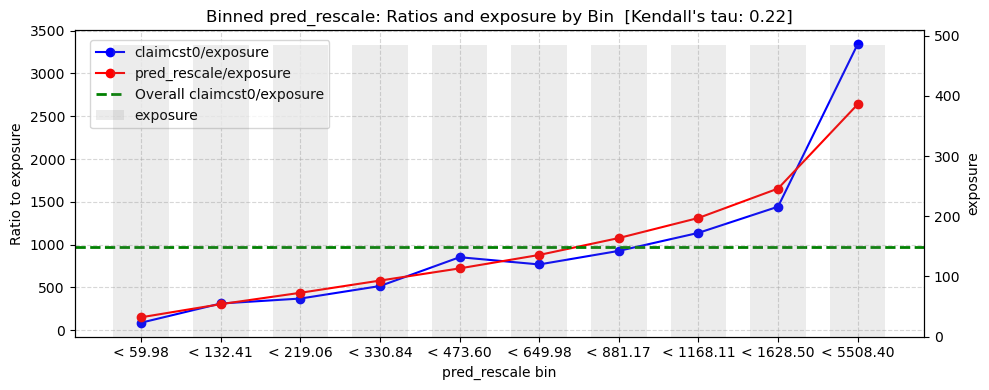

In [80]:
# Select training samples for predictiveness check
data = final_model_data

# Define variables
exp_var = 'exposure'
pred_var = 'pred_rescale'
var_1 = 'claimcst0'
var_2 = 'pred_rescale'
nbins = 10


# Create and run PredictivenessCheck
pc = PredictivenessCheck(
    df=data,
    pred_var=pred_var,
    exp_var=exp_var,
    var_1=var_1,
    var_2=var_2
)

pc.binning(nbins=nbins)
pc.aggregate()

# Compute top lift
pc.top_lift()

# Compute R^2, RMSE, and MAE
me = ModelEvaluation(data[var_1], data[var_2])
gini = me.gini()
rmse = me.rmse()
mae = me.mae()

# Print results
print(f"Top Lift: {pc.top_lift:.4f}")
print(f"Gini: {gini:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
pc.plot(figsize=(10, 4))

    1. Top Lift = 3.41
This means:

The top 10% of customers ranked by your model have 3.41× higher average loss than the portfolio overall.

That is very strong uplift.

In pricing/underwriting terms:

Your model sharply concentrates high-risk policies at the top of the predicted distribution.

If used in segmentation, the high-risk group would contain a disproportionate share of actual losses.

This is excellent for identifying high-loss segments and building risk tiers.

    2. Gini = 0.6682
A Gini of 0.67 is exceptionally high for an insurance severity or pure-premium model.

Interpretation:

The model improves risk ranking by 66.8% relative to random — indicating excellent discriminatory power.

This means:

The model is extremely good at sorting customers from low to high expected loss.

It provides highly actionable ranking for underwriting, risk segmentation, and pricing.

Even if absolute predictions are noisy (due to claim rarity), the ordering is outstanding.

    3. RMSE = 1722.59 & MAE = 685.50
Interpretation:

On average, the prediction misses the true claim cost per exposure by $685.

Large errors occur due to the heavy tail (RMSE is much larger than MAE).

This is exactly what you expect:

Losses are infrequent but severe when they occur.

RMSE is dominated by rare high-cost claims.

MAE represents a more realistic “average miss”.




In [83]:
# Model metrics on Training Data

# MAE
y_pred = model.predict(dtrain)
mae = mean_absolute_error(y, y_pred)
print(f"Training MAE: {mae:.2f}")

# Tweedie Deviance
tweedie_dev = mean_tweedie_deviance(
    y_true=y,
    y_pred=y_pred,
    power=1.5    # same as model.tweedie_variance_power
)
print(f"Training Tweedie Deviance: {tweedie_dev:.2f}")

# Gini Coefficient

Training MAE: 593.91
Training Tweedie Deviance: 87.40


In [84]:
# Model metrics on Validation Data
# calculate feature importance
importance = model.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
}).sort_values(by='Importance', ascending=False)
importance_df

,Feature,Importance
0,driving_history_score,964.911377
10,veh_age,961.947571
1,credit_score,945.657104
5,agecat_grouped,937.783203
2,marital_status,908.640259
8,max_power,899.068970
7,veh_color,896.479980
11,veh_value,894.971008
4,area,807.446899
3,time_driven,773.373718


## Risk Segmentation

### Quantiles

In [19]:
train_data['predicted_expected_loss'] = y_pred

train_data.head()

/var/folders/nj/nbmj9gh56g9b50kd52cy7mwr0000gn/T/ipykernel_8963/2966020220.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['predicted_expected_loss'] = y_pred


,id,fold,sample,veh_value,exposure,veh_body,veh_age,gender,area,agecat,...,time_of_week_driven,time_driven,trm_len,credit_score,low_education_ind,clm,numclaims,claimcst0,expected_loss,predicted_expected_loss
0,1,2,1|bld,5.80,0.362191,SUV,2,F,B,1,...,weekday,12pm - 6pm,6,646.516469,0.0,1,1,2023.198184,5585.998969,4190.744101
1,2,3,1|bld,5.67,0.632068,STNWG,4,F,A,2,...,weekend,6am - 12pm,12,635.400369,0.0,1,1,3600.172234,5695.859540,5273.055427
2,3,1,1|bld,5.90,0.367460,SEDAN,2,F,C,2,...,weekday,6am - 12pm,12,646.463131,0.0,1,1,2021.144067,5500.307127,4220.612971
3,4,2,1|bld,4.79,0.802184,STNWG,3,M,B,4,...,weekday,6pm - 12am,12,645.598794,0.0,1,1,4006.845492,4994.920513,3422.488947
4,5,2,1|bld,6.68,0.485009,SEDAN,3,M,C,1,...,weekday,6am - 12pm,12,657.348612,0.0,1,1,2542.953931,5243.106060,3485.267952


In [20]:
train_data["expected_loss"].quantile([0.33, 0.66])

0.33    0.0
0.66    0.0
Name: expected_loss, dtype: float64

### Fixed Thresholds

### KMeans Clustering

## Save Altered Data

In [ ]:
model_data.to_csv('../project/model_data.csv', index=False)
inference_data.to_csv('../project/inference_data.csv', index=False)

## Export Model Artifacts

In [24]:
# 1) Save the trained RandomForestRegressor
joblib.dump(rf, "../project/models/rf_model.pkl")

# 2) Save the exact feature column order used to fit the model
feature_columns = list(X_train.columns)  # if you trained with a DataFrame
with open("../project/models/feature_columns.json", "w") as f:
    json.dump(feature_columns, f)

# 3) (Optional) Create simple risk cutoffs from training predictions